In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, split

spark = (SparkSession.builder
         .appName("taxi-analysis")
         .master("local[5]")
         .getOrCreate()
         )

24/03/25 16:54:56 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [23]:
trips_path = '../../data/trips/*'
zone_path = '../../data/taxi_zone_lookup.csv'
trips_df = spark.read.options(inferSchema=True, header=True).format('parquet').load(trips_path)
zone_df = spark.read.options(inferSchema=True, header=True).format('csv').load("../../data/taxi_zone_lookup.csv")

In [18]:
trips_df.printSchema()

root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: double (nullable = true)


In [25]:
zone_df.printSchema()

root
 |-- LocationID: integer (nullable = true)
 |-- Borough: string (nullable = true)
 |-- Zone: string (nullable = true)
 |-- service_zone: string (nullable = true)


In [26]:
zone_df.createOrReplaceTempView("zone")
trips_df.createOrReplaceTempView("trips")

In [27]:
query = """
SELECT 
    t.VendorID as vendor_id,
    TO_DATE(t.tpep_pickup_datetime) as pickup_date,
    TO_DATE(t.tpep_dropoff_datetime) as dropoff_date,
    HOUR(t.tpep_pickup_datetime) as pickup_time,
    HOUR(t.tpep_dropoff_datetime) as dropoff_time,
    t.passenger_count,
    t.trip_distance,
    t.fare_amount,
    t.tip_amount,
    t.tolls_amount,
    t.total_amount,
    t.payment_type,
    pz.Zone as pickup_zone,
    dz.Zone as dropoff_zone
FROM 
    trips t
    LEFT JOIN 
        zone pz
    ON
        t.PULocationID = pz.LocationID
    LEFT JOIN
        zone dz
    ON 
        t.DOLocationID = dz.LocationID
"""
trips_with_location = spark.sql(query)

In [28]:
trips_with_location.printSchema()

root
 |-- vendor_id: long (nullable = true)
 |-- pickup_date: date (nullable = true)
 |-- dropoff_date: date (nullable = true)
 |-- pickup_time: integer (nullable = true)
 |-- dropoff_time: integer (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- pickup_zone: string (nullable = true)
 |-- dropoff_zone: string (nullable = true)


In [33]:
trips_with_location.createOrReplaceTempView("trips_with_location")
spark.sql("""
    SELECT *
    FROM trips_with_location
""").show()

+---------+-----------+------------+-----------+------------+---------------+-------------+-----------+----------+------------+------------+------------+--------------------+--------------------+
|vendor_id|pickup_date|dropoff_date|pickup_time|dropoff_time|passenger_count|trip_distance|fare_amount|tip_amount|tolls_amount|total_amount|payment_type|         pickup_zone|        dropoff_zone|
+---------+-----------+------------+-----------+------------+---------------+-------------+-----------+----------+------------+------------+------------+--------------------+--------------------+
|        2| 2021-03-01|  2021-03-01|          0|           0|            1.0|          0.0|        3.0|       0.0|         0.0|         4.3|           2|                 N/A|                 N/A|
|        2| 2021-03-01|  2021-03-01|          0|           0|            1.0|          0.0|        2.5|       0.0|         0.0|         3.8|           2|      Manhattanville|      Manhattanville|
|        2| 2021-03-

In [36]:
# 이상치 탐색
spark.sql("""
    SELECT
        *
    FROM trips_with_location as t1
    WHERE t1.pickup_date not between '2021-01-01' and '2021-07-31'
""").show()

+---------+-----------+------------+-----------+------------+---------------+-------------+-----------+----------+------------+------------+------------+--------------------+--------------------+
|vendor_id|pickup_date|dropoff_date|pickup_time|dropoff_time|passenger_count|trip_distance|fare_amount|tip_amount|tolls_amount|total_amount|payment_type|         pickup_zone|        dropoff_zone|
+---------+-----------+------------+-----------+------------+---------------+-------------+-----------+----------+------------+------------+------------+--------------------+--------------------+
|        2| 2009-01-01|  2009-01-01|          0|          14|            1.0|         3.09|       17.0|       1.0|         0.0|        21.3|           1| Lincoln Square West|      Yorkville East|
|        2| 2008-12-31|  2008-12-31|         23|          23|            1.0|         0.55|        4.5|       0.0|         0.0|         5.3|           2|             Erasmus|Prospect-Lefferts...|
|        2| 2009-01-

In [37]:
trips_with_location.select(col('total_amount')).describe().show()  # 요금

+-------+------------------+
|summary|      total_amount|
+-------+------------------+
|  count|          15000936|
|   mean| 18.75540051097825|
| stddev|145.74310219085987|
|    min|            -647.8|
|    max|          398469.2|
+-------+------------------+


In [39]:
trips_with_location.select("trip_distance").describe().show()  # 거리

+-------+-----------------+
|summary|    trip_distance|
+-------+-----------------+
|  count|         15000936|
|   mean|6.628556730059907|
| stddev| 671.724064548099|
|    min|              0.0|
|    max|        332541.19|
+-------+-----------------+


In [40]:
trips_with_location.select("passenger_count").describe().show()  # 승객 수

+-------+------------------+
|summary|   passenger_count|
+-------+------------------+
|  count|          14166908|
|   mean|1.4253582362502812|
| stddev|1.0443336003189163|
|    min|               0.0|
|    max|               9.0|
+-------+------------------+


In [46]:
# 월단위 Group

spark.sql("""
SELECT
    DATE_TRUNC('MM', t1.pickup_date) AS pickup_month,
    count(1)
FROM trips_with_location as t1
GROUP BY pickup_month
ORDER BY 1
""").show()

+-------------------+--------+
|       pickup_month|count(1)|
+-------------------+--------+
|2002-12-01 00:00:00|       1|
|2003-01-01 00:00:00|       1|
|2004-04-01 00:00:00|       1|
|2008-12-01 00:00:00|      26|
|2009-01-01 00:00:00|     111|
|2020-12-01 00:00:00|      16|
|2021-01-01 00:00:00| 1369753|
|2021-02-01 00:00:00| 1371689|
|2021-03-01 00:00:00| 1925130|
|2021-04-01 00:00:00| 2171215|
|2021-05-01 00:00:00| 2507075|
|2021-06-01 00:00:00| 2834204|
|2021-07-01 00:00:00| 2821661|
|2021-08-01 00:00:00|      36|
|2021-09-01 00:00:00|       3|
|2021-10-01 00:00:00|       3|
|2021-11-01 00:00:00|       5|
|2021-12-01 00:00:00|       5|
|2029-05-01 00:00:00|       1|
+-------------------+--------+


In [47]:
cleaned_trips_data = spark.sql("""
    SELECT
        *
    FROM trips_with_location as t1
    WHERE
        t1.total_amount < 5000
        AND t1.total_amount > 0
        AND t1.trip_distance < 100
        AND t1.passenger_count < 5
        AND t1.pickup_date >= '2021-01-01'
        AND t1.pickup_date < '2021-08-01'
""")

In [49]:
cleaned_trips_data.createOrReplaceTempView("cleaned_trips")

In [50]:
# 분석 및 시각화

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

<Axes: xlabel='pickup_date', ylabel='pickup_count'>

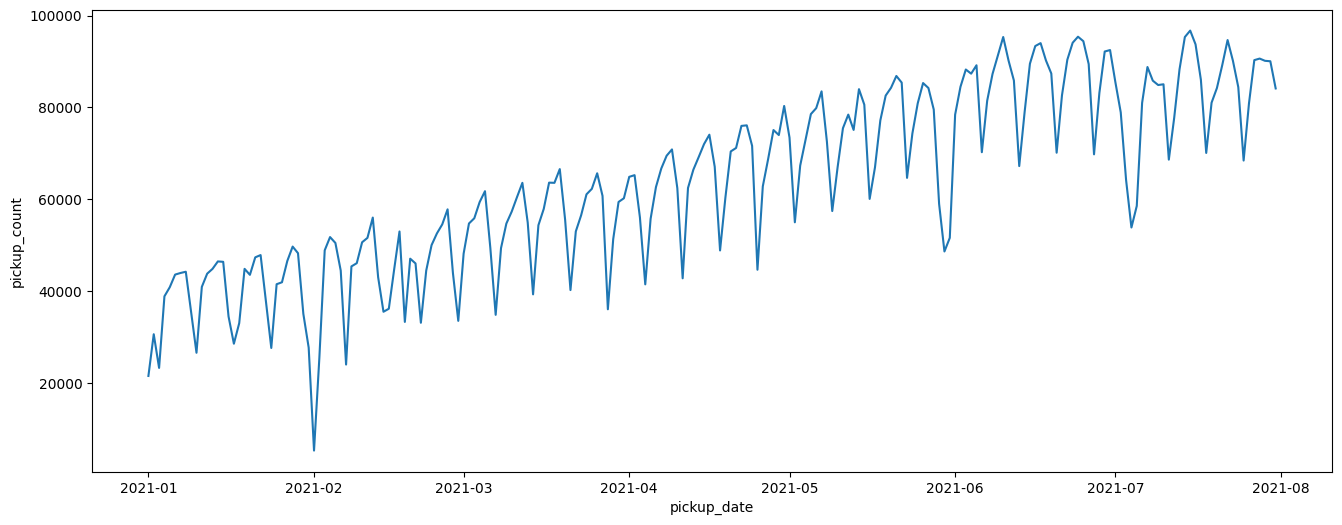

In [54]:
# 일별 운행 수

pickup_date_to_pandas = spark.sql("""
    SELECT
        t1.pickup_date,
        count(1) as pickup_count
    FROM cleaned_trips as t1
    GROUP BY t1.pickup_date
""").toPandas()

fig, ax = plt.subplots(figsize=(16, 6))
sns.lineplot(x='pickup_date', y='pickup_count', data=pickup_date_to_pandas)

In [55]:
# 요일별 운행 수

pickup_day_of_week_to_pandas = spark.sql("""
    SELECT
        t1.pickup_date,
        DATE_FORMAT(t1.pickup_date, 'EEEE') AS day_of_week,
        count(1) as pickup_count
    from cleaned_trips as t1
    GROUP BY t1.pickup_date, day_of_week
""").toPandas()

In [56]:
pickup_day_of_week_to_pandas.head()

,pickup_date,day_of_week,pickup_count
0,2021-03-24,Wednesday,61095
1,2021-03-27,Saturday,60760
2,2021-03-03,Wednesday,55886
3,2021-03-05,Friday,61779
4,2021-03-09,Tuesday,54728


In [57]:
data = pickup_day_of_week_to_pandas.groupby("day_of_week").pickup_count.median().to_frame().reset_index()

In [58]:
data

,day_of_week,pickup_count
0,Friday,74073.0
1,Monday,57165.0
2,Saturday,62455.0
3,Sunday,43748.5
4,Thursday,73011.0
5,Tuesday,67613.5
6,Wednesday,70195.5


In [59]:
data['sort_dow'] = data['day_of_week'].replace({
    "Sunday": 0,
    "Monday": 1,
    "Tuesday": 2,
    "Wednesday": 3,
    "Thursday": 4,
    "Friday": 5,
    "Saturday": 6,
})

In [60]:
data

,day_of_week,pickup_count,sort_dow
0,Friday,74073.0,5
1,Monday,57165.0,1
2,Saturday,62455.0,6
3,Sunday,43748.5,0
4,Thursday,73011.0,4
5,Tuesday,67613.5,2
6,Wednesday,70195.5,3


In [61]:
data.sort_values(by='sort_dow', inplace=True)

In [62]:
data

,day_of_week,pickup_count,sort_dow
3,Sunday,43748.5,0
1,Monday,57165.0,1
5,Tuesday,67613.5,2
6,Wednesday,70195.5,3
4,Thursday,73011.0,4
0,Friday,74073.0,5
2,Saturday,62455.0,6


<Axes: xlabel='day_of_week', ylabel='pickup_count'>

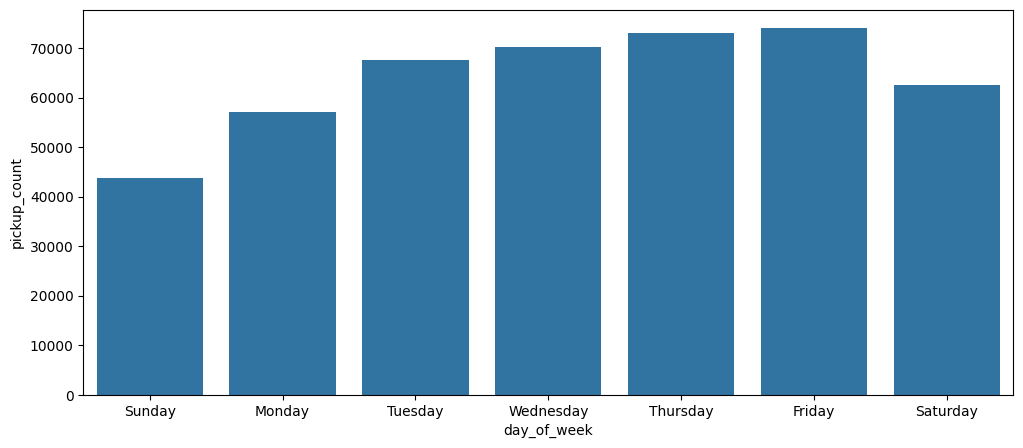

In [65]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(
    x="day_of_week",
    y="pickup_count",
    data=data
)

In [69]:
payment_type_to_string = {
    1: "Credit Card",
    2: "Cash",
    3: "No Charge",   # 계산되지 않음
    4: "Dispute",     # 분쟁이 있었음
    5: "Unknown",
    6: "Voided Trip", # 취소된 운행
}
def parse_payment_type(payment_type):
    return payment_type_to_string[payment_type]

spark.udf.register("parse_payment_type", parse_payment_type)


query = """
SELECT 
    parse_payment_type(t1.payment_type),
    count(*) AS trips,
    MEAN(t1.fare_amount) AS mean_fare_amount,
    STD(t1.fare_amount) AS stdev_fare_amount
FROM
    cleaned_trips as t1
GROUP BY
    payment_type
"""

spark.sql(query).show()

24/03/25 17:36:18 WARN SimpleFunctionRegistry: The function parse_payment_type replaced a previously registered function.


+--------------------------------+--------+------------------+------------------+
|parse_payment_type(payment_type)|   trips|  mean_fare_amount| stdev_fare_amount|
+--------------------------------+--------+------------------+------------------+
|                     Credit Card|10264113| 12.22903129671156|10.829167433394183|
|                       No Charge|   59146|11.978507084164598|15.075517698204939|
|                            Cash| 3152075|12.013733102797323|11.525458490191864|
|                         Dispute|   23809| 12.70040656894452|14.233591295666047|
|                         Unknown|       1|              17.8|              null|
+--------------------------------+--------+------------------+------------------+
